In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from pathlib import Path #The pathlib is a Python module which provides an object API for working with files and directories. The pathlib is a standard module. Path is the core object to work with files.


from sklearn import * # importing all libraries from sklearn

from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.utils import shuffle

from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications import EfficientNetB3,EfficientNetB2,EfficientNetB1,EfficientNetB7,EfficientNetB0,Xception
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

**Defining Directory**

In [36]:
img_path=Path('../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls') # woking with 3 class
image_link=list(img_path.glob(r'**/*.*')) # image link
image_Names=[x.parents[0].stem for x in image_link] #labels name
df=pd.DataFrame(list(zip(image_link,image_Names)),columns=['Link','Name'])

In [37]:
np.unique(df.Name) # need to drop "Control" bcz of 'CONTROL_AD' & 'CONTROL_PD'

array(['AD', 'CONTROL', 'PD'], dtype=object)

In [86]:
labels = ['AD','CONTROL', 'PD']

In [38]:
# df=df[df.Name!="CONTROL"] # drop "Control"
df['Labels']=preprocessing.LabelEncoder().fit_transform(df.Name) # create image name labels

In [39]:
np.unique(df.Labels) #After data set

array([0, 1, 2])

<h1>Plot</h1>

<AxesSubplot:>

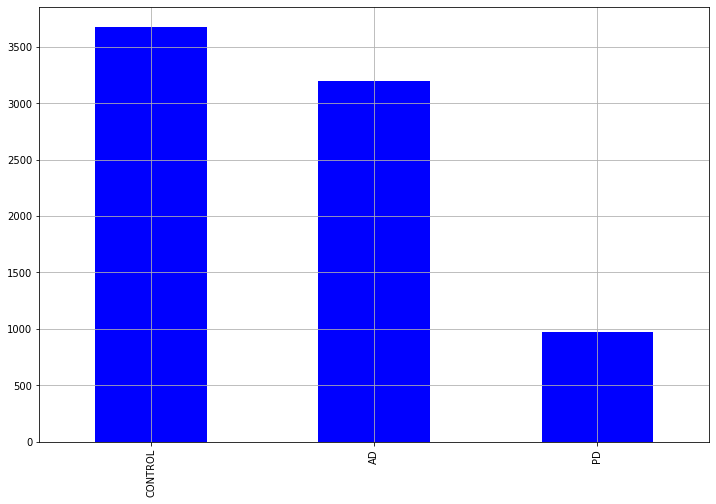

In [40]:
df['Name'].value_counts().plot(kind='bar',figsize = (12,8), grid = True,color = 'blue')

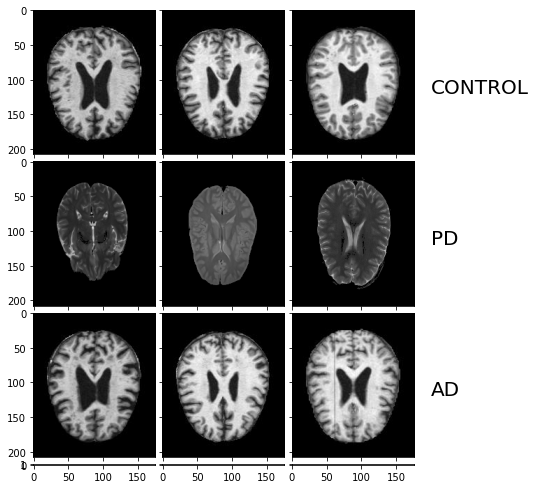

In [41]:
fig = plt.figure(1, figsize=(15, 15))
grid = ImageGrid(fig,121, nrows_ncols=(4, 3), axes_pad=0.10)
i = 0
for category_id, category in enumerate(df.Name.unique()):
    for filepath in df[df['Name'] == category]['Link'].values[:3]:
        ax = grid[i]
        img = image.load_img(filepath, (150, 150))
        img=image.img_to_array(img)
        ax.imshow(img/255)
        #ax.axis('off')
        if i % 3 == 3 - 1:
            ax.text(200, 111, category, verticalalignment='center',fontsize=20,color = 'k')
        
            
        i+=1
    
plt.show();

* <h2>Split labels,class and tarin,test:</h2>
+    <h3>train Data </h3>
+   <h3>test data</h3>

In [46]:
x=df.Link
y=df.Labels
x_data,y_data=shuffle(x,y,random_state=42) #data shuffle for better result
xtrain,xtest,ytrain,ytest=model_selection.train_test_split(x_data, y_data, test_size=0.1, random_state=42)

<h2>Train and Test image to data format:</h2>

In [48]:
img_size=150
X_train=[]
X_test=[]
for i in xtrain:   # train img formatting
    img_pre=cv2.imread(str(i))
    img_pre=cv2.resize(img_pre, (img_size,img_size))
    X_train.append(img_pre)
    
    
for i in xtest:    # test img formatting
    img_pre=cv2.imread(str(i))
    img_pre=cv2.resize(img_pre, (img_size,img_size))
    X_test.append(img_pre)
    
    
X_train=np.array(X_train)
X_test=np.array(X_test)

ytrain=to_categorical(ytrain)
ytest=to_categorical(ytest)

__<h2>Create model with EfficientNetB7 </h2>__

In [49]:
efficient = EfficientNetB7(weights='imagenet',include_top = False, input_shape=(img_size, img_size, 3))

2022-10-29 13:14:05.791949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 13:14:05.915254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 13:14:05.916118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 13:14:05.917611: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

258088960/258076736 [==============================] - 3s 0us/step


In [51]:
model = efficient.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.3)(model)
model = tf.keras.layers.Dense(3, activation = "softmax")(model)
model = tf.keras.models.Model(inputs = efficient.input , outputs = model)



In [53]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [54]:
# https://keras.io/api/models/model_training_apis/
model.compile(loss = 'categorical_crossentropy', 
             optimizer = "Adam", 
              metrics=["accuracy"]
             )  

In [55]:
tensorboard = TensorBoard(log_dir="logs")  #TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more. This callback logs events for TensorBoard, including:Metrics summary plots,Training graph visualization,Weight, histograms,Sampled profiling


2022-10-29 13:26:36.640180: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-29 13:26:36.640232: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-29 13:26:36.642160: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-10-29 13:26:36.793416: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-29 13:26:36.793611: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


**ModelCheckpoint**

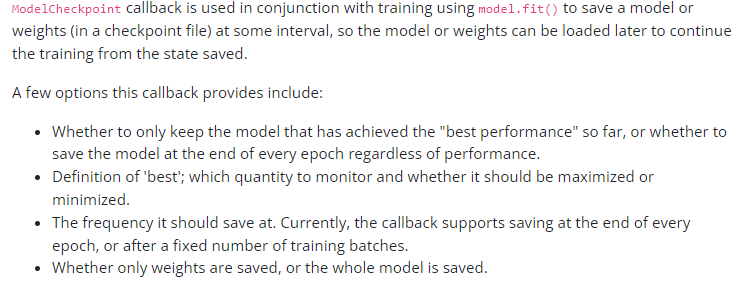

In [56]:
checkpoint = ModelCheckpoint("efficientB7.h5", 
                            monitor='val_accuracy', 
                            mode = "auto", 
                            verbose = 1,
                            save_best_only =True)

**Reduce LR**

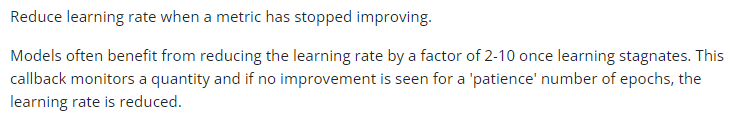

In [57]:
reduce_LR = ReduceLROnPlateau(monitor="val_accuracy", 
                             factor = 0.3, 
                             patience = 2, 
                             min_delta=0.001, 
                             mode = "auto", 
                            verbose = 1)

__<h2>Fit model with EfficientNetB7 </h2>__

In [59]:
history = model.fit(X_train, ytrain,
                  validation_data =(X_test,ytest), 
                  epochs = 15, 
                  verbose =1, 
                  batch_size = 32, 
                  callbacks = [tensorboard, checkpoint, reduce_LR])

Epoch 1/15
  1/221 [..............................] - ETA: 2:14 - loss: 0.3117 - accuracy: 0.8125

2022-10-29 13:35:28.588475: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-29 13:35:28.588528: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/221 [..............................] - ETA: 6:27 - loss: 0.2822 - accuracy: 0.8750

2022-10-29 13:35:29.554005: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-29 13:35:29.560634: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-29 13:35:29.803195: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 7265 callback api events and 7262 activity events. 
2022-10-29 13:35:29.976010: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-29 13:35:30.426990: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_10_29_13_35_29

2022-10-29 13:35:30.748031: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_10_29_13_35_29/1de16aa77bb2.trace.json.gz
2022-10-29 13:35:31.318701: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/pl

221/221 [==============================] - 145s 657ms/step - loss: 0.2880 - accuracy: 0.8774 - val_loss: 0.9363 - val_accuracy: 0.7130

Epoch 00001: val_accuracy improved from -inf to 0.71301, saving model to efficientB7.h5
Epoch 2/15
221/221 [==============================] - 138s 624ms/step - loss: 0.1838 - accuracy: 0.9236 - val_loss: 0.3322 - val_accuracy: 0.8954

Epoch 00002: val_accuracy improved from 0.71301 to 0.89541, saving model to efficientB7.h5
Epoch 3/15
221/221 [==============================] - 138s 624ms/step - loss: 0.1390 - accuracy: 0.9461 - val_loss: 0.2485 - val_accuracy: 0.9145

Epoch 00003: val_accuracy improved from 0.89541 to 0.91454, saving model to efficientB7.h5
Epoch 4/15
221/221 [==============================] - 136s 616ms/step - loss: 0.1001 - accuracy: 0.9663 - val_loss: 0.1618 - val_accuracy: 0.9311

Epoch 00004: val_accuracy improved from 0.91454 to 0.93112, saving model to efficientB7.h5
Epoch 5/15
221/221 [==============================] - 138s 625

In [60]:
df_accuracy=pd.DataFrame()
df_accuracy['Loss']=history.history['loss']
df_accuracy['Value Loss']=history.history['val_loss']
df_accuracy['Accuracy']=history.history['accuracy']
df_accuracy['Value Accuracy']=history.history['val_accuracy']

df_accuracy

,Loss,Value Loss,Accuracy,Value Accuracy
0,0.287971,0.936278,0.877392,0.713010
1,0.183829,0.332246,0.923600,0.895408
2,0.138973,0.248453,0.946137,0.914541
3,0.100073,0.161832,0.966265,0.931122
4,0.059688,2.758619,0.978455,0.570153
5,0.064245,0.147747,0.977321,0.948980
6,0.041896,0.251836,0.984975,0.936224
7,0.042501,0.144934,0.985259,0.948980
8,0.014538,0.024394,0.995464,0.989796
9,0.002409,0.017922,0.999291,0.997449


In [67]:
pred = model.predict(X_test)
pred = np.argmax(ytest, axis =1)
ytest = np.argmax(ytest, axis =1)

In [69]:
from sklearn.metrics import classification_report, confusion_matrix

In [70]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       335
           1       1.00      1.00      1.00       357
           2       1.00      1.00      1.00        92

    accuracy                           1.00       784
   macro avg       1.00      1.00      1.00       784
weighted avg       1.00      1.00      1.00       784



__<h2>Plot for best performance with EfficientNetB7 </h2>__

<AxesSubplot:>

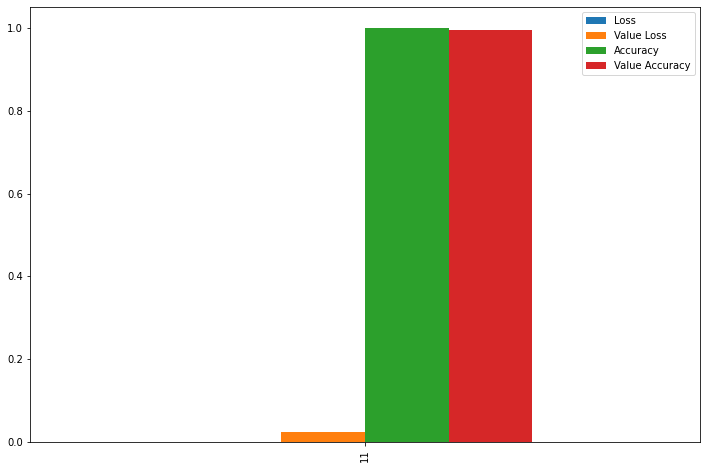

In [79]:
# for the 9th epoch
df_accuracy.sort_values('Loss',ascending=True).head(1).plot(kind='bar',figsize = (12,8))

__<h2>Visualization for Accuracy & Loss</h2>__

In [97]:
def plot_hist(hist):
    
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    plt.plot(hist.history["accuracy"], 'bo--', label="accuracy")
    plt.plot(hist.history["val_accuracy"], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.grid()
    plt.legend()
    plt.tight_layout()
  
    
    plt.subplot(222)
    plt.plot(hist.history["loss"], "bo--", label="loss")
    plt.plot(hist.history["val_loss"], "ro--", label = "val_loss")
    plt.title("Training Data Loss")
    plt.ylabel("Loss")
    plt.xlabel("epoch")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()



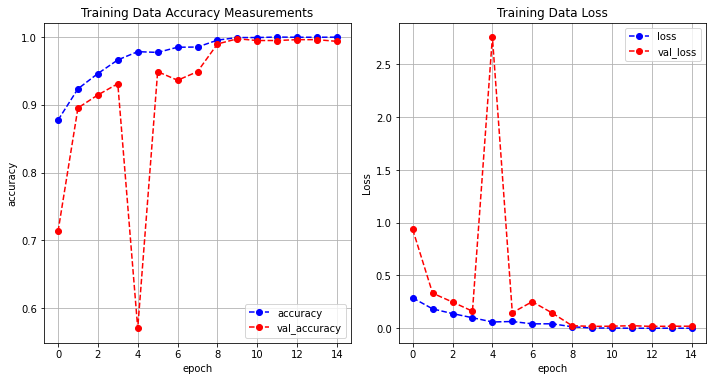

In [98]:
plot_hist(history)

In [82]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

<AxesSubplot:>

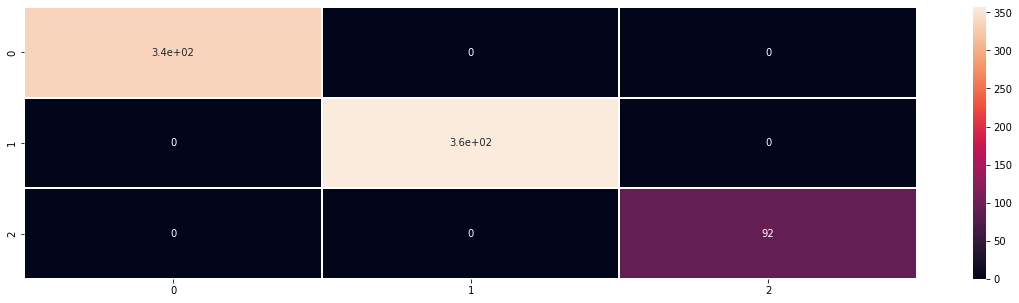

In [83]:
cm=confusion_matrix(ytest, pred)
fig, ax = plt.subplots(figsize=(20,5)) 
sns.heatmap(cm, annot=True, linewidths=2, ax=ax)

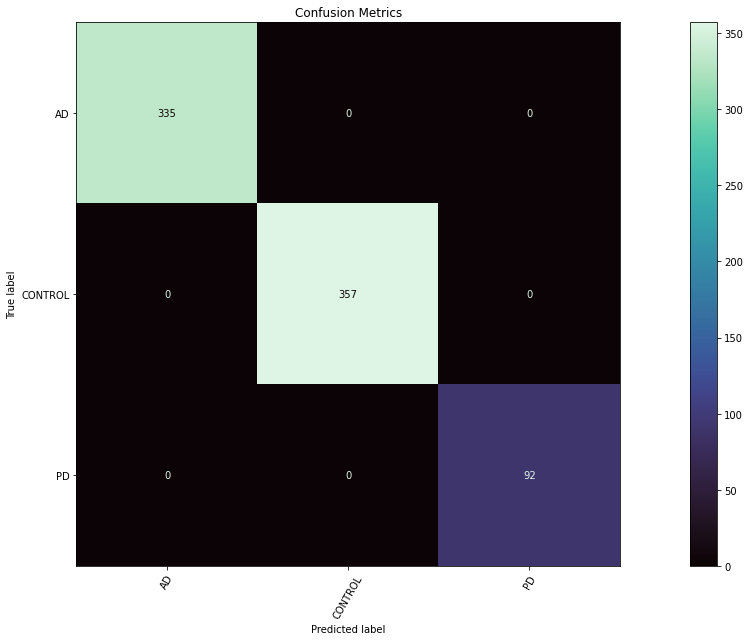

In [87]:
display_c_m = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(25,10)) 
display_c_m.plot(cmap='mako',ax=ax,xticks_rotation=60)
plt.title("Confusion Metrics")
plt.show()
